# **What you will learn in this notebook**

*   Understanding how to tune hyperparameters
*   Save and Load pytorch models

In [2]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
!pip install skorch
from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.4/239.4 kB 1.7 MB/s eta 0:00:00


In [3]:
cars_file = "https://gist.githubusercontent.com/noamross/e5d3e859aa0c794be10b/raw/b999fb4425b54c63cab088c0ce2c0d6ce961a563/cars.csv"

In [4]:
cars = pd.read_csv(cars_file)
cars.head()

,Unnamed: 0,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


<Axes: xlabel='wt', ylabel='mpg'>

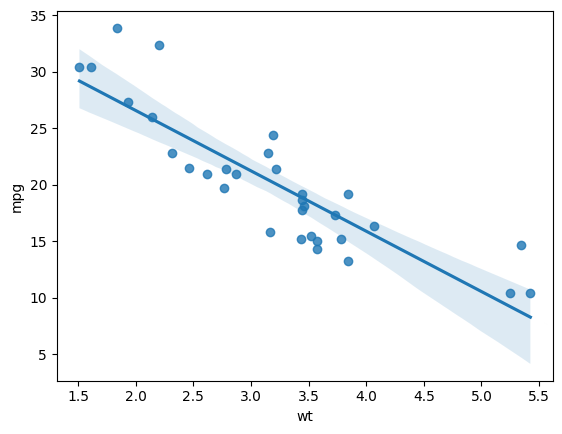

In [5]:
sns.regplot(x='wt', y='mpg', data=cars)

In [16]:
# define custom dataloader class for linear regression
class LinearrRegressionDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    return self.X[index], self.y[index]

# define a torch model for linear regression
class LinearrRegressionModel(nn.Module):
  def __init__(self, input_size=1, output_size=1):
    super(LinearrRegressionModel, self).__init__()
    self.linear = nn.Linear(in_features=input_size, out_features=output_size)

  def forward(self, x):
    return self.linear(x)

In [7]:
# prepare dataset
X_list = cars.wt.values
X_np = np.array(X_list, dtype=np.float32).reshape(-1, 1)

y_list = cars.mpg.values
y_np = np.array(y_list, dtype=np.float32).reshape(-1, 1)

In [8]:
# hyperparamters

BATCH_SIZE = 1
learning_rate = 0.01
num_epochs = 1000

train_loader = DataLoader(dataset=LinearrRegressionDataset(X_np, y_np), batch_size=BATCH_SIZE)

In [9]:
model = LinearrRegressionModel(input_size=1, output_size=1)
criterion = nn.MSELoss()  # loss function
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [10]:
# Training Loop
for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:
        # Forward pass
        y_pred = model(X_batch)

        # calculate loss b/w predicted and ground truth values
        # print(y_pred.shape, y_batch.shape)
        loss = criterion(y_pred, y_batch)

        # remove (zero) the previous gradients
        optimizer.zero_grad()

        # backward pass (backpropagation)
        loss.backward()

        # update parameters
        optimizer.step()


    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/1000], Loss: 0.3350
Epoch [200/1000], Loss: 0.2607
Epoch [300/1000], Loss: 0.2595
Epoch [400/1000], Loss: 0.2595
Epoch [500/1000], Loss: 0.2595
Epoch [600/1000], Loss: 0.2595
Epoch [700/1000], Loss: 0.2595
Epoch [800/1000], Loss: 0.2595
Epoch [900/1000], Loss: 0.2595
Epoch [1000/1000], Loss: 0.2595


In [11]:
# extract the learned weight and bias for linear regression
# y = weight * x + bias

weight = model.linear.weight.data[0]
bias = model.linear.bias[0].data

<Axes: xlabel='wt', ylabel='mpg'>

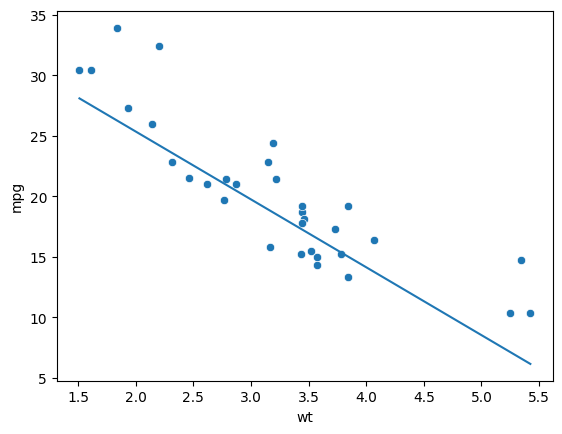

In [12]:
# visualize the results
y_pred = X_list*weight.detach().numpy() + bias.detach().numpy()
sns.scatterplot(x='wt', y='mpg', data=cars)
sns.lineplot(x=X_list, y=y_pred)

# **Save and Load Models**

There are two methods to save and load models.

1. **Using model state dictionary**

  **Advantages:**

  * **Portability**: The state_dict is lightweight and easily transferable.
  * **Flexibility**: Allows loading the weights into different architectures, provided they have the same layer structure.
  
  **Disadvantages:**

  * Requires model definition: You need to have the model class definition available in your code to load the state_dict.

2. **Using overall model**

  **Advantages:**

  * **Convenience**: You don’t need to redefine the model class when loading the model. This can be useful when deploying models.
  
  **Disadvantages:**

  * **Less Portable**: The saved model file can be larger and less flexible.
  * **Dependency on Codebase**: The entire model object is saved, which can cause issues with version compatibility and dependencies.
  * **Potential for Issues with Pickling**: Since torch.save uses pickle, any issues with pickling (e.g., changes in class definitions, incompatible versions) can lead to problems when loading the model.



Method 1

In [22]:
# save the model state dict
torch.save(model.state_dict(), 'model_state_dict.pth')

In [24]:
# To load the model state dict, first you need to load the model
model = LinearrRegressionModel(1, 1)  # same parameters to the args before saving
model.load_state_dict(torch.load('model_state_dict.pth')) # same name during saving
model

LinearrRegressionModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

Method 2

In [25]:
torch.save(model, "model.pt")

In [26]:
model = torch.load('model.pt')
model

LinearrRegressionModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

# **Tuning hyperparamters**

In [20]:
net = NeuralNetRegressor(
    LinearrRegressionModel,
    max_epochs=1000,
    lr=learning_rate,
    iterator_train__shuffle = True
)
net.set_params(train_split=False, verbose=0)
params = {
    'lr': [0.02, 0.05, 0.08],
    'max_epochs': [10, 500, 900]
}
gs = GridSearchCV(net, params, scoring='r2', cv=3, verbose=2)

X = torch.from_numpy(X_np)
y_true = torch.from_numpy(y_np)

gs.fit(X, y_true)

print(f"\nbest score: {gs.best_score_}, best_params: {gs.best_params_}")

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END .............................lr=0.02, max_epochs=10; total time=   0.1s
[CV] END .............................lr=0.02, max_epochs=10; total time=   0.0s
[CV] END .............................lr=0.02, max_epochs=10; total time=   0.1s
[CV] END ............................lr=0.02, max_epochs=500; total time=   2.3s
[CV] END ............................lr=0.02, max_epochs=500; total time=   1.3s
[CV] END ............................lr=0.02, max_epochs=500; total time=   2.2s
[CV] END ............................lr=0.02, max_epochs=900; total time=   2.5s
[CV] END ............................lr=0.02, max_epochs=900; total time=   2.3s
[CV] END ............................lr=0.02, max_epochs=900; total time=   2.6s
[CV] END .............................lr=0.05, max_epochs=10; total time=   0.0s
[CV] END .............................lr=0.05, max_epochs=10; total time=   0.0s
[CV] END .............................lr=0.05, ma

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:927: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0, dtype=np.float64)


[CV] END ............................lr=0.08, max_epochs=900; total time=   2.4s
[CV] END ............................lr=0.08, max_epochs=900; total time=   2.5s
[CV] END ............................lr=0.08, max_epochs=900; total time=   2.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py", line 911, in r2_score
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py", line 102, in _check_reg_targets
    y_pred = check_array(y_pred, en


best score: 0.589244589562385, best_params: {'lr': 0.05, 'max_epochs': 900}
